<a href="https://colab.research.google.com/github/LADISLAOCOSTILLO/ARCHIVOSGIT/blob/main/Spark_ML_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PRÁCTICA SPARK CLUSTERING K-MEANS**
#APRENDIZAJE NO SUPERVISADO

In [ ]:
 for archivo in os.listdir():
    print(archivo)

In [1]:
!pip install pyspark
!pip install findspark

# Importar SparkSession
from pyspark.sql import SparkSession

# Crear una Sesión de Spark
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Consultar la información de la Sesión de Spark
spark

In [2]:
# (1) Importar las dependencias de Python requeridas
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
from skimage import img_as_float

import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector

In [3]:
# (2) Crear una instancia de contexto de Spark
sqlContext = SQLContext(spark)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Mounted at /content/drive


Text(0.5, 1.0, 'MRI Scan de un cerebro SANO para entrenar nuestro Modelo de Clustering de K-Medias no supervisado\n')

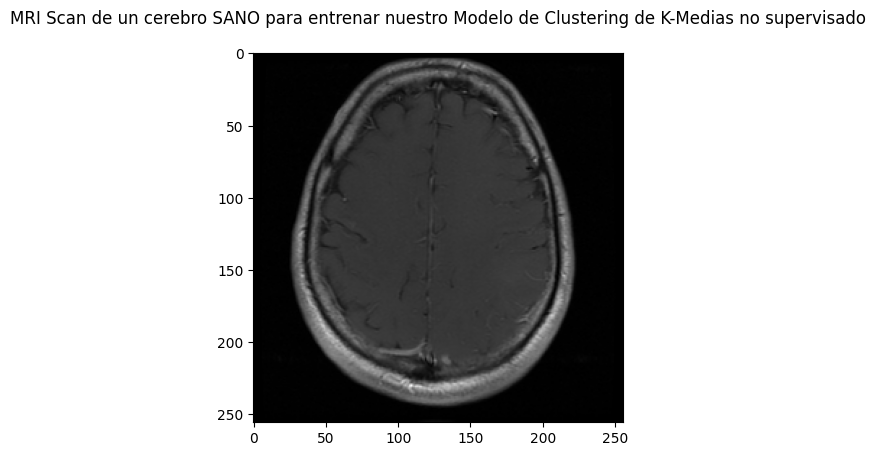

In [7]:
# (3) Cargar MRI scan (resonancia magnética) perteneciente al cerebro SANO
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
mri_healthy_brain_image = io.imread('/content/drive/MyDrive/mri-healthy-brain.png')
mri_healthy_brain_image_plot = plt.imshow(mri_healthy_brain_image, cmap='gray')
plt.title("MRI Scan de un cerebro SANO para entrenar nuestro Modelo de Clustering de K-Medias no supervisado\n")

In [8]:
# (4) Convertir nuestro Training MRI Scan en una Matriz de Valores de Intensidad de Píxeles entre 0 y 1
mri_healthy_brain_matrix = img_as_float(mri_healthy_brain_image)
print("MRI Scan saludable - MATRIZ de Intensidad de Valores de Píxeles: \n")
print(mri_healthy_brain_matrix)
print("\nMRI Scan saludable - Dimensiones de la MATRIZ (ancho x alto en px): \n")
print(mri_healthy_brain_matrix.shape)

MRI Scan saludable - MATRIZ de Intensidad de Valores de Píxeles: 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

MRI Scan saludable - Dimensiones de la MATRIZ (ancho x alto en px): 

(256, 256)


In [9]:
# (5) Convertir la Matriz en un vector plano, es decir, matriz de dimensiones 1 x N
mri_healthy_brain_2d_array = np.array(mri_healthy_brain_matrix).astype(float)
mri_healthy_brain_1d_array = mri_healthy_brain_2d_array.ravel()
mri_healthy_brain_vector = np.matrix(mri_healthy_brain_1d_array)

print("MRI Scan saludable - Vector Plano i.e. Matriz de Dimensiones 1 x N: \n")
print(mri_healthy_brain_vector)
print("\nMRI Scan saludable - Dimensiones del Vector Plano: \n")
print(mri_healthy_brain_vector.shape)

MRI Scan saludable - Vector Plano i.e. Matriz de Dimensiones 1 x N: 

[[0. 0. 0. ... 0. 0. 0.]]

MRI Scan saludable - Dimensiones del Vector Plano: 

(1, 65536)


In [10]:
# (6) Convertir Vector Plano en un Spark DataFrame donde cada fila corresponde a un único valor de intensidad de píxel
mri_healthy_brain_vector_transposed = mri_healthy_brain_vector.reshape(
    mri_healthy_brain_vector.shape[1], mri_healthy_brain_vector.shape[0])
print("MRI Scan saludable - Vector transpuesto i.e. matriz de dimensiones N x 1: ")
print(mri_healthy_brain_vector_transposed)
print("\nMRI Scan saludable - Dimensions del Vector transpuesto: \n")
print(mri_healthy_brain_vector_transposed.shape)

mri_healthy_brain_df = sqlContext.createDataFrame(pd.DataFrame(mri_healthy_brain_vector_transposed, columns=['pixel_intensity']))
print("\nMRI Scan saludable - \033[1m\033[4mDISTRIBUTED\033[0m Spark DataFrame of Pixel Intensity Values: \n")
mri_healthy_brain_df.show()
mri_healthy_brain_df.dtypes

MRI Scan saludable - Vector transpuesto i.e. matriz de dimensiones N x 1: 
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]

MRI Scan saludable - Dimensions del Vector transpuesto: 

(65536, 1)

MRI Scan saludable - DISTRIBUTED Spark DataFrame of Pixel Intensity Values: 

+---------------+
|pixel_intensity|
+---------------+
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
|            0.0|
+---------------+
only showing top 20 rows



[('pixel_intensity', 'double')]

In [11]:
# (7) Generar vectores de características de entrada a partir de los Valores de Intensidad de Píxeles de Spark DataFrame
feature_columns = ['pixel_intensity']
vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
print("MRI Scan saludable - Vectores de Características de Intensidad de Píxeles: \n")
mri_healthy_brain_features_df = vector_assembler.transform(mri_healthy_brain_df).select('features')
mri_healthy_brain_features_df.show()
mri_healthy_brain_features_df.dtypes

MRI Scan saludable - Vectores de Características de Intensidad de Píxeles: 

+--------+
|features|
+--------+
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
|   [0.0]|
+--------+
only showing top 20 rows



[('features', 'vector')]

In [12]:
[('features', 'vector')]

[('features', 'vector')]

In [13]:
# (9) Entrenar un modelo Clustering K-Means basado en los vectores de características de intensidad de píxeles de una MRI Brain Scan Sana
k = 5
kmeans = KMeans().setK(k).setSeed(12345).setFeaturesCol("features")
kmeans_model = kmeans.fit(mri_healthy_brain_features_df)
kmeans_centers = kmeans_model.clusterCenters()
print("MRI Scan SALUDABLE - K-Means Cluster Centers: \n")
for center in kmeans_centers:
    print(center)

MRI Scan SALUDABLE - K-Means Cluster Centers: 

[0.21857225]
[0.00765946]
[0.56251348]
[0.37761313]
[0.13331494]


Healthy MRI Scan - Pixels mapped to 1 ... K Clusters (K = 5): 

+--------+----------+
|features|prediction|
+--------+----------+
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
|   [0.0]|         1|
+--------+----------+
only showing top 20 rows


Healthy MRI Scan - Visualización de Cluster: 



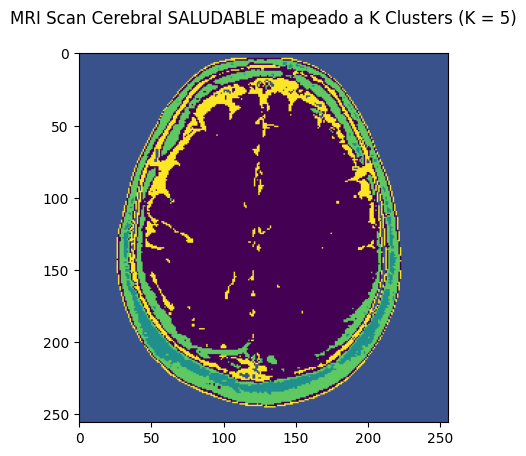

In [14]:
# (10) Asignar Píxeles a Clusters en la imagen MRI Brain Scan SALUDABLE y visualizar los K Clusters
mri_healthy_brain_clusters_df = kmeans_model.transform(mri_healthy_brain_features_df).select('features', 'prediction')
print("Healthy MRI Scan - Pixels mapped to 1 ... K Clusters (K = %d): \n" % k)
mri_healthy_brain_clusters_df.show()
print("\nHealthy MRI Scan - Visualización de Cluster: \n")
mri_healthy_brain_clusters_matrix = mri_healthy_brain_clusters_df.select("prediction").toPandas().values.reshape(
    mri_healthy_brain_matrix.shape[0], mri_healthy_brain_matrix.shape[1])
plt.imshow(mri_healthy_brain_clusters_matrix)
plt.title("MRI Scan Cerebral SALUDABLE mapeado a K Clusters (K = %d)\n" % k)
plt.show()

Text(0.5, 1.0, 'MRI Scan de otro Cerebro para el TEST de nuestro Modelo Clustering K-Means Unsupervised\n')

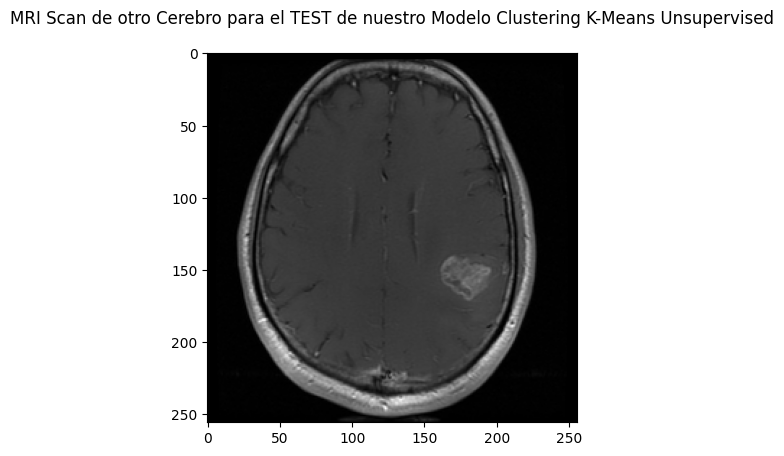

In [15]:
# (11) Cargar MRI Scan perteneciente a otro Cerebro para probar (Test) nuestro Modelo Clustering K-Means
mri_test_brain_image = io.imread('/content/drive/MyDrive/mri-test-brain.png')
mri_test_brain_image_plot = plt.imshow(mri_test_brain_image, cmap='gray')
plt.title("MRI Scan de otro Cerebro para el TEST de nuestro Modelo Clustering K-Means Unsupervised\n")

\Test MRI Scan - Visualización de Cluster: 



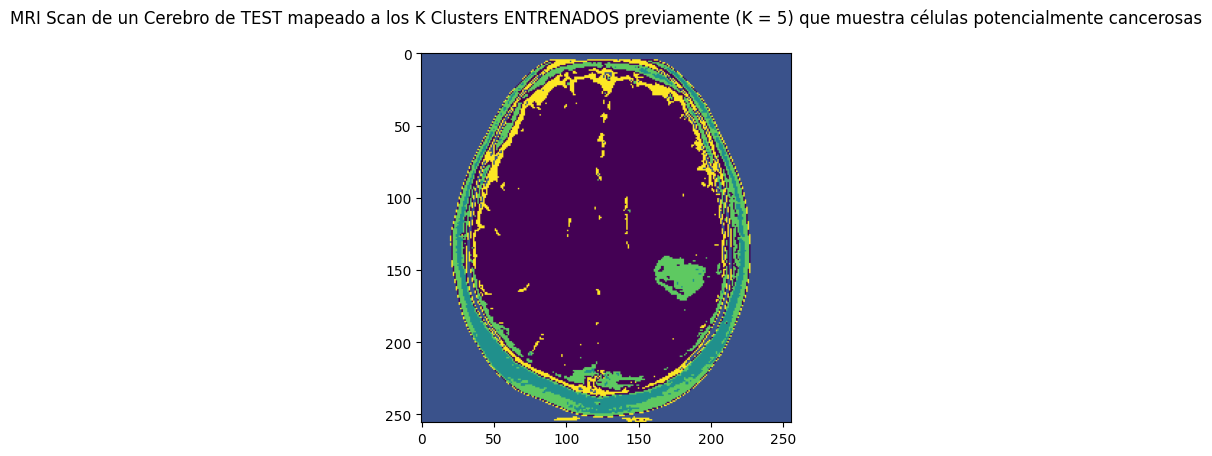

In [16]:
# (12) Aplicar el Modelo Clustering K-Means entrenado al TEST MRI Scan
# El siguiente código se puede parametrizar mediante funciones de Python para reducir la duplicación de código.
mri_test_brain_matrix = img_as_float(mri_test_brain_image)
mri_test_brain_2d_array = np.array(mri_test_brain_matrix).astype(float)
mri_test_brain_1d_array = mri_test_brain_2d_array.ravel()
mri_test_brain_vector = np.matrix(mri_test_brain_1d_array)
mri_test_brain_vector_transposed = mri_test_brain_vector.reshape(
    mri_test_brain_vector.shape[1], mri_test_brain_vector.shape[0])
mri_test_brain_df = sqlContext.createDataFrame(pd.DataFrame(mri_test_brain_vector_transposed, columns=['pixel_intensity']))
mri_test_brain_features_df = vector_assembler.transform(mri_test_brain_df).select('features')

mri_test_brain_clusters_df = kmeans_model.transform(mri_test_brain_features_df).select('features', 'prediction')
print("\Test MRI Scan - Visualización de Cluster: \n")
mri_test_brain_clusters_matrix = mri_test_brain_clusters_df.select("prediction").toPandas().values.reshape(
    mri_test_brain_matrix.shape[0], mri_test_brain_matrix.shape[1])
plt.imshow(mri_test_brain_clusters_matrix)
plt.title("MRI Scan de un Cerebro de TEST mapeado a los K Clusters ENTRENADOS previamente (K = %d) que muestra células potencialmente cancerosas\n" % k)
plt.show()

In [ ]:
# (13) Finalizar el Spark Context
spark.stop()